# Group 12 Mini-project

## Dependencies

We assume a conda virtual environment is existing and selected as the kernel to run this notebook. It can be created and activated using:
```
conda env create -f environment.yml
source activate generative_prompt
```


In [2]:
# Navigate into the source code

%cd ../src/cycle-diffusion

[WinError 2] The system cannot find the file specified: '../src/cycle-diffusion'
c:\Users\Alon\Documents\GitHub\cycle_diffusion_group12\demos


In [ ]:
!pip install git+https://github.com/openai/CLIP.git

2. Install torch and torchvision

In [ ]:
!conda install -y pytorch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1 pytorch-cuda=11.7 -c pytorch -c nvidia

3. Install taming-transformer

In [ ]:
%cd ..

In [ ]:
!git clone https://github.com/CompVis/taming-transformers.git
%cd taming-transformers/
!pip install -e .

In [ ]:
%cd ..

4. login to wandDB, adapt the configuration function,`setup_wandb()`, in `main.py`.


## Evaluation data
4 Prepare the AFHQ validation set for unpaired image-to-image translation (also for some images used by zero-shot image-to-image translation)

In [ ]:
%cd src/cycle-diffusion/
!git clone https://github.com/clovaai/stargan-v2.git
%cd stargan-v2/
!bash download.sh afhq-v2-dataset

In [ ]:
%cd ..

## Pre-trained diffusion models

5. Stable Diffusion

In [ ]:
%cd ckpts/
!mkdir stable_diffusion
%cd stable_diffusion/
!wget https://huggingface.co/CompVis/stable-diffusion-v-1-4-original/resolve/main/sd-v1-4.ckpt

In [ ]:
%cd ..

6. Latent Diffusion Model

In [ ]:
!wget https://www.dropbox.com/s/9lpdgs83l7tjk6c/ldm_models.zip
!unzip ldm_models.zip
!rm ldm_models.zip 

%cd ldm_models/
!mkdir text2img-large
%cd text2img-large/
!wget https://ommer-lab.com/files/latent-diffusion/nitro/txt2img-f8-large/model.ckpt
!wget https://www.dropbox.com/s/7pdttimz78ll0km/txt2img-1p4B-eval.yaml

In [ ]:
%cd ../..

7. DDPM (AFHQ-Dog and FFHQ are from ILVR; CelebAHQ is from SDEdit; AFHQ-Cat and -Wild are trained by ourselves)

In [ ]:
!mkdir ddpm
%cd ddpm/
# !wget https://image-editing-test-12345.s3-us-west-2.amazonaws.com/checkpoints/celeba_hq.ckpt #TODO did not work
!wget https://www.dropbox.com/s/g4h8sv07i3hj83d/ffhq_10m.pt
!wget https://www.dropbox.com/s/u74w8vaw1f8lc4k/afhq_dog_4m.pt
!wget https://www.dropbox.com/s/8i5aznjwdl3b5iq/cat_ema_0.9999_050000.pt
!wget https://www.dropbox.com/s/tplximipy8zxaub/wild_ema_0.9999_050000.pt
!wget https://www.dropbox.com/s/vqm6bxj0zslrjxv/configs.zip
!unzip configs.zip

In [ ]:
%cd ../../../..

## Run

In [13]:
%cd cycle-diffusion

[WinError 2] The system cannot find the file specified: 'cycle-diffusion'
c:\Users\Alon\Documents\GitHub\cycle-diffusion-group12\src\cycle-diffusion


In [175]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from PIL import Image
import os
from tqdm import tqdm
import csv

def pass_filter(img, ftype, radius=32):
    # do dft saving as complex output
    dft = np.fft.fft2(img, axes=(0,1))

    # apply shift of origin to center of image
    dft_shift = np.fft.fftshift(dft)

    # generate spectrum from magnitude image (for viewing only)
    mag = np.abs(dft_shift)
    spec = np.log(mag) / 20

    # create circle mask
    mask = np.zeros_like(img)
    cy = mask.shape[0] // 2
    cx = mask.shape[1] // 2
    cv2.circle(mask, (cx,cy), radius, (255,255,255), -1)[0]
    if ftype == 'high':
        mask = 255 - mask

    # blur the mask
    mask = cv2.GaussianBlur(mask, (19,19), 0)

    # apply mask to dft_shift
    dft_shift_masked = np.multiply(dft_shift,mask) / 255


    # shift origin from center to upper left corner
    back_ishift = np.fft.ifftshift(dft_shift)
    back_ishift_masked = np.fft.ifftshift(dft_shift_masked)


    # do idft saving as complex output
    img_back = np.fft.ifft2(back_ishift, axes=(0,1))
    img_filtered = np.fft.ifft2(back_ishift_masked, axes=(0,1))

    # combine complex real and imaginary components to form (the magnitude for) the original image again
    img_back = np.abs(img_back).clip(0,255).astype(np.uint8)
    img_filtered = np.abs(img_filtered).clip(0,255).astype(np.uint8)

    if ftype == 'high':
        img_filtered = np.abs(3*img_filtered).clip(0,255).astype(np.uint8)
    else:
        img_filtered = np.abs(img_filtered).clip(0,255).astype(np.uint8)

    return img_filtered

### Plot and save images

In [184]:
img_cat = imread('stargan-test/data/test/cat/flickr_cat_000008.png')
img_cat_low = pass_filter(img_cat, 'low', 5)
img_cat_high = pass_filter(img_cat, 'high', 10)

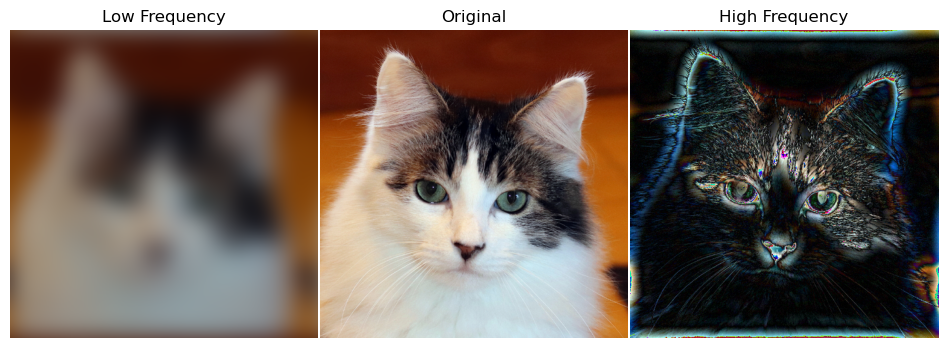

In [185]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))


axes[0].imshow(img_cat_low)
axes[0].axis('off')
axes[0].set_title('Low Frequency')

axes[1].imshow(img_cat)
axes[1].axis('off')
axes[1].set_title('Original')

axes[2].imshow(img_cat_high)
axes[2].axis('off')
axes[2].set_title('High Frequency')


# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0, wspace=0)

# Show the figure
plt.show()

In [ ]:
# Create folders for the filtered cat images and for the dog images that will be generated.
%cd stargan-v2
%mkdir cat_high
%mkdir cat_low
%mkdir gen_dog
%mkdir gen_dog_high
%mkdir gen_dog_low
%cd ..

In [174]:
folder_path = "stargan-v2/cat/"
num_images = 50
count = 0

for i, filename in tqdm(enumerate(os.listdir(folder_path))):
    if count >= num_images: break

    if filename.endswith(".png"):

        image_path = os.path.join(folder_path, filename)
        image = imread(image_path)

        # Rename original image.
        old_file = os.path.join(folder_path, filename)
        new_file = os.path.join(folder_path, f"img_cat_org_{i}.png")
        os.rename(old_file, new_file)
        
        # Apply the high/low pass filter and save the images.
        img_cat_low = pass_filter(image, 'low', 5)
        cat_low = Image.fromarray(img_cat_low)
        cat_low.save(f"stargan-v2/cat_low/img_cat_low_{i}.png")

        img_cat_high = pass_filter(image, 'high', 10)
        cat_high = Image.fromarray(img_cat_high)
        cat_high.save(f"stargan-v2/cat_high/img_cat_high_{i}.png")

        count += 1
        

50it [00:22,  2.23it/s]


### Run cycle diffusion (DDPM)

In [91]:
#TODO: Run it on the following three folder names cat, cat_high and cat_low

!./test.job

### Compare generated images using the Structural Similarity Index Measure (SSIM).

In [ ]:
from evaluation.utils import calculate_ssim

# Get a list of image file names in the folder
gen_dog_files = sorted([f for f in os.listdir("stargan-v2/gen_dog/") if f.endswith(".png")])
gen_dog_high_files = sorted([f for f in os.listdir("stargan-v2/gen_dog_high/") if f.endswith(".png")])
gen_dog_low_files = sorted([f for f in os.listdir("stargan-v2/gen_dog_low/") if f.endswith(".png")])

# List to store the scores
scores_high = []
scores_low = []

# Calculate SSIM scores between original generated image and low / high pass filtered generated images
for i in range(len(gen_dog_files)):
    gen_dog_file = gen_dog_files[i]
    gen_dog_high_file = gen_dog_high_files[i]
    gen_dog_low_file = gen_dog_low_files[i]

    gen_dog_path = os.path.join("stargan-v2/gen_dog/", gen_dog_file)
    gen_dog_high_path = os.path.join("stargan-v2/gen_dog_high/", gen_dog_high_file)
    gen_dog_low_path = os.path.join("stargan-v2/gen_dog_low/", gen_dog_low_file)

    gen_dog = imread(gen_dog_path)
    gen_dog_high = imread(gen_dog_high_path)
    gen_dog_low = imread(gen_dog_low_path)
    
    scores_high.append(calculate_ssim(gen_dog, gen_dog_high))
    scores_low.append(calculate_ssim(gen_dog, gen_dog_low))


# Save the scores to a CSV file
csv_file = "scores.csv"
header = ["SSIM High", "SSIM Low"]

with open(csv_file, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(header)
    writer.writerows(zip(scores_high, scores_low))

In [ ]:
def ssim_stats(list):
    scores_np = np.array(list)
    mean = np.mean(scores_np)
    std = np.std(scores_np)
    return mean, std

mean_high, std_high = ssim_stats(scores_high)
mean_low, std_low = ssim_stats(scores_low)

In [ ]:
print("SSIM Scores - Generated images vs generated high pass filter images")
print("Mean: {:.4f}".format(mean_high))
print("Standard Deviation: {:.4f}\n\n".format(std_high))

print("SSIM Scores - Generated images vs generated low pass filter images")
print("Mean: {:.4f}".format(mean_low))
print("Standard Deviation: {:.4f}".format(std_low))

##  (old)

In [193]:
# import torchvision.transforms as transforms
# from preprocess.afhqwild256 import INTERPOLATION
# from PIL import Image

# def resize_image(im):
#     im_pil = Image.fromarray(im)
#     transform = transforms.Compose([
#         transforms.Resize(256, interpolation=INTERPOLATION),  # 512 -> 256
#         transforms.ToTensor()
#     ])
#     return transform(im_pil)

# orig_cat = resize_image(img_cat)

# orig_high_cat = resize_image(img_cat_high)
# orig_low_cat = resize_image(img_cat_low)

# Resize images: (512, 512) -> (256, 256) for comparison.
orig_cat = cv2.resize(img_cat, (256, 256))

orig_high_cat = cv2.resize(img_cat_high, (256, 256))
orig_low_cat = cv2.resize(img_cat_low, (256, 256))




gen_dog1 = imread("stargan-test/data/test/dog0.png")
gen_dog2 = imread("stargan-test/data/test/dog1.png")

gen_high_dog1 = imread("stargan-test/data/test/high_dog0.png")
gen_high_dog2 = imread("stargan-test/data/test/high_dog1.png")

gen_low_dog1 = imread("stargan-test/data/test/low_dog0.png")
gen_low_dog2 = imread("stargan-test/data/test/low_dog1.png")

In [179]:
def plot_images(image1, image2, title):
    # Create a figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Plot the first image
    axes[0].imshow(image1)
    axes[0].axis('off')

    # Plot the second image
    axes[1].imshow(image2)
    axes[1].axis('off')

    # Add title above the images
    fig.suptitle(title, fontsize=16, y=0.95)

    # Add text below the images
    ssim_score = round(calculate_ssim(image1, image2), 3)
    fig.text(0.5, 0.05, f" SSIM: {ssim_score}", ha='center', fontsize=12)

    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0, wspace=0)

    # Show the plot
    plt.show()

## Compare images with consecutive sample sets

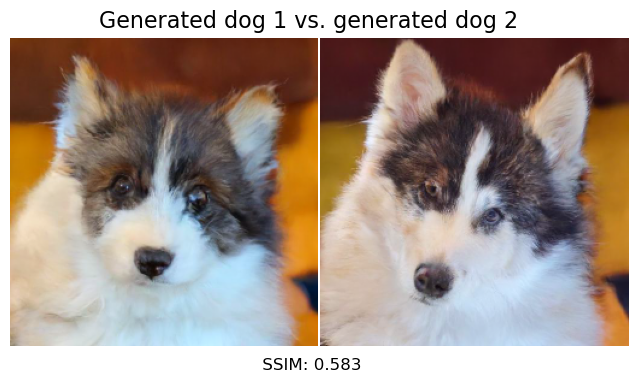

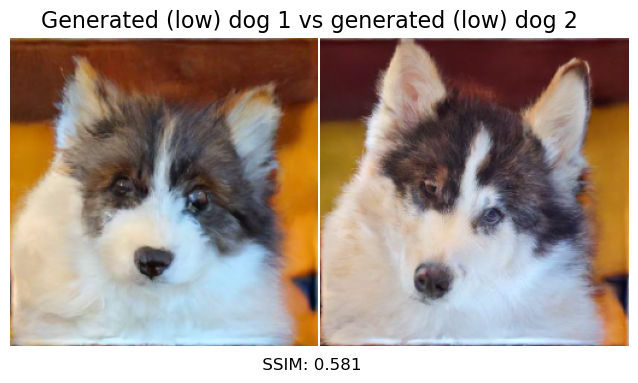

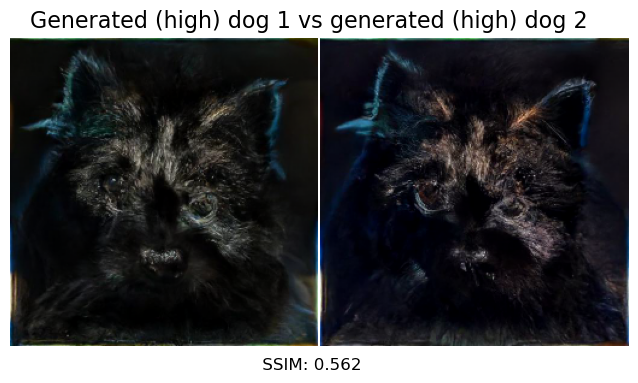

In [180]:
plot_images(gen_dog1, gen_dog2, 'Generated dog 1 vs. generated dog 2')
plot_images(gen_low_dog1, gen_low_dog2, 'Generated (low) dog 1 vs generated (low) dog 2')
plot_images(gen_high_dog1, gen_high_dog2, 'Generated (high) dog 1 vs generated (high) dog 2')

## Comparing generated image with image that was used as input

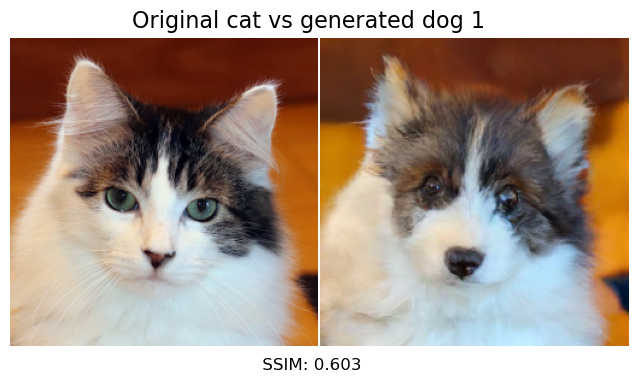

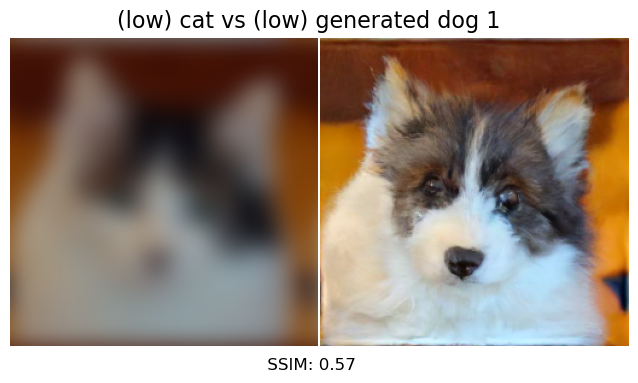

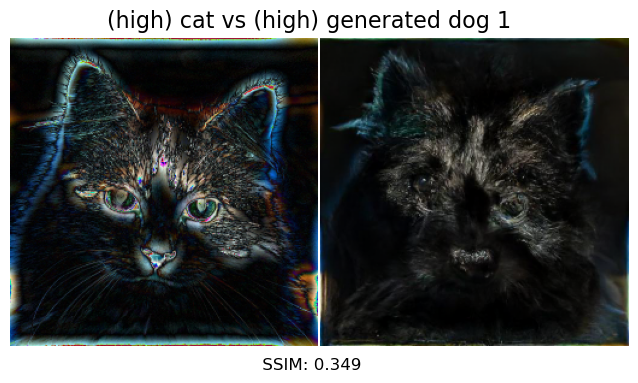

In [194]:
plot_images(orig_cat, gen_dog1, 'Original cat vs generated dog 1')
plot_images(orig_low_cat, gen_low_dog1, '(low) cat vs (low) generated dog 1')
plot_images(orig_high_cat, gen_high_dog1, '(high) cat vs (high) generated dog 1')

## Comparing generated high/low filtered images with image generated from the original

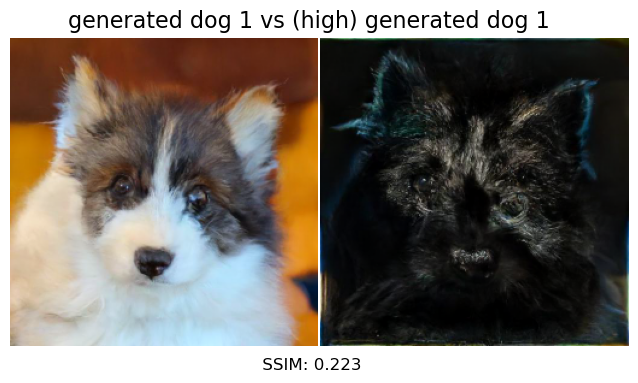

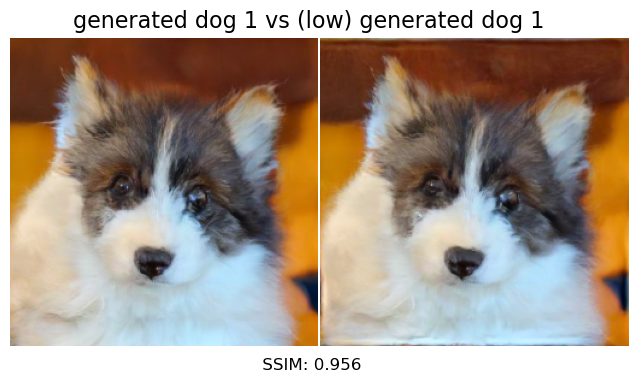

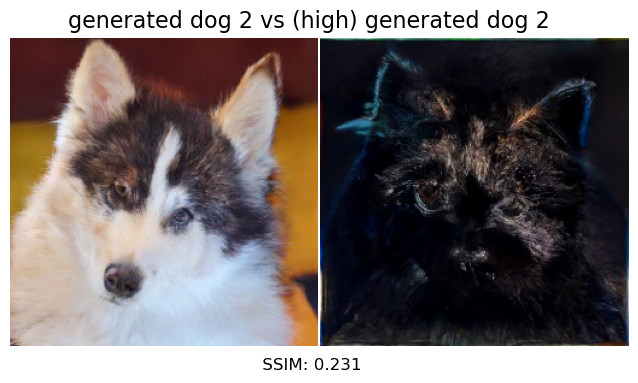

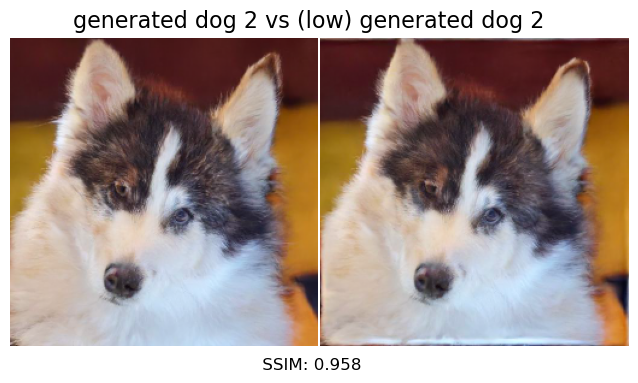

In [195]:
plot_images(gen_dog1, gen_high_dog1, 'generated dog 1 vs (high) generated dog 1')
plot_images(gen_dog1, gen_low_dog1, 'generated dog 1 vs (low) generated dog 1')
plot_images(gen_dog2, gen_high_dog2, 'generated dog 2 vs (high) generated dog 2')
plot_images(gen_dog2, gen_low_dog2, 'generated dog 2 vs (low) generated dog 2')

In [ ]:
# cos sim between low pass latent space and original latent space
# cos sim between high pass latent space and original latent space